# Script to create ImageFolder format for tooth sample data

https://pytorch.org/vision/main/generated/torchvision.datasets.ImageFolder.html

also: augment data to get balanced classes

structure

torch_imagefolder/mpi/m,p,i

torch_imagefolder/upperlower/upper,lower

-> no predetermined train and test sets to not fit to particular train/test split


In [123]:
import cv2
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import os

In [208]:
# borderValue: color to use in fill-in pixels after translation
def translate(image, tx, ty, borderValue = (255,255,255)):
    M = np.array([[1.,0.,tx],[0.,1.,ty]])
    height, width = image.shape[:2]
    translated_image = cv2.warpAffine(src=image, M=M, dsize=(width, height), borderMode=cv2.BORDER_CONSTANT, borderValue=borderValue)
    return translated_image

In [244]:
# script parameters
data_versions = [3,4,5,7]
image_path = '/home/riikoro/fossil_data/tooth_samples'

0. Create labels.txt where they are missing
1. Get all images with labels
2. Create directory torch_imagefolder, subfolders upperlower and MPI with subdirectories for all classes
2. MPI: check balances -> augment so that balances equal
3. Divide into M P and I
5. Save images to MPI folders
6. Upper and lower: check balances, augment if necessary
7. Divide into upper lower
8. Save images to upper lower folders

In [245]:
# 1. Get all labels
def clean_azure_labels(data_version):
    tooth_labels = pd.read_csv(f'{image_path}/v{data_version}/labels.txt')
    tooth_labels['tooth_type'] = tooth_labels['tooth'].str[0] # extract first character
    del tooth_labels['tooth']
    # set labels where tooth type is unexpected to none
    tooth_labels.loc[~tooth_labels['tooth_type'].isin(['m', 'p', 'i', 'M', 'P', 'I']), 'tooth_type'] = None
    # uppercase all tooth type letters
    tooth_labels['tooth_type'] = tooth_labels['tooth_type'].str.upper()
    # add column for image index & data version to allow combining datasets
    tooth_labels['image_i'] = tooth_labels.index
    tooth_labels['data_v'] = data_version
    tooth_labels['u'] = tooth_labels['u'].astype('Int64') # pandas automatically converts to int due to nones present
    return tooth_labels

label_dfs = []
for data_v in data_versions:
    label_dfs.append(clean_azure_labels(data_v))

tooth_labels = pd.concat(label_dfs, axis=0)
tooth_labels.reset_index(drop=True, inplace=True)
tooth_labels

,u,tooth_type,image_i,data_v
0,1,M,0,3
1,0,None,1,3
2,0,None,2,3
3,0,M,3,3
4,1,P,4,3
...,...,...,...,...
424,1,M,52,7
425,1,P,53,7
426,1,M,54,7
427,1,I,55,7


In [246]:
# 1. Get all images
filenames = []
for i, label in tooth_labels.iterrows():
    filename = f'{image_path}/v{label["data_v"]}/{label["image_i"]}.png'
    filenames.append(filename)

tooth_labels['image_path'] = filenames

In [235]:
# try creating new directory with torch_imagefolder_i name until a nonreserved directory name is found (to not overwrite previous data versions)
# follow the structure from https://pytorch.org/vision/main/generated/torchvision.datasets.ImageFolder.html
i = 0
while(1):
    try:
        os.mkdir(f'{image_path}/torch_imagefolder_{i}')
        os.mkdir(f'{image_path}/torch_imagefolder_{i}/MPI')
        os.mkdir(f'{image_path}/torch_imagefolder_{i}/MPI/train')
        os.mkdir(f'{image_path}/torch_imagefolder_{i}/MPI/train/M')
        os.mkdir(f'{image_path}/torch_imagefolder_{i}/MPI/train/P')
        os.mkdir(f'{image_path}/torch_imagefolder_{i}/MPI/train/I')
        os.mkdir(f'{image_path}/torch_imagefolder_{i}/MPI/test')
        os.mkdir(f'{image_path}/torch_imagefolder_{i}/MPI/test/M')
        os.mkdir(f'{image_path}/torch_imagefolder_{i}/MPI/test/P')
        os.mkdir(f'{image_path}/torch_imagefolder_{i}/MPI/test/I')
        os.mkdir(f'{image_path}/torch_imagefolder_{i}/upperlower')
        os.mkdir(f'{image_path}/torch_imagefolder_{i}/upperlower/train')
        os.mkdir(f'{image_path}/torch_imagefolder_{i}/upperlower/test')
        os.mkdir(f'{image_path}/torch_imagefolder_{i}/upperlower/train/upper')
        os.mkdir(f'{image_path}/torch_imagefolder_{i}/upperlower/train/lower')
        os.mkdir(f'{image_path}/torch_imagefolder_{i}/upperlower/test/upper')
        os.mkdir(f'{image_path}/torch_imagefolder_{i}/upperlower/test/lower')
        break
    except FileExistsError:
        i += 1
        continue
torch_imagefolder_path = f'{image_path}/torch_imagefolder_{i}'
torch_imagefolder_path

'/home/riikoro/fossil_data/tooth_samples/torch_imagefolder_2'

### Save M, P, I, upper lower to new folders

In [247]:
from sklearn.model_selection import train_test_split

tooth_labels['mpi_dataset'] = 'train'
tooth_labels['u_dataset'] = 'train'

# tooth_labels
defined_mpi = tooth_labels[tooth_labels['tooth_type'].isin(['M', 'P', 'I'])]
mpitrain, mpitest = train_test_split(defined_mpi.index, test_size = 0.1, random_state=4)
# upper, lower
defined_u = tooth_labels[tooth_labels['u'].isin([0,1])]
utrain, utest = train_test_split(defined_u.index, test_size = 0.1, random_state=7)

tooth_labels.loc[mpitest, 'mpi_dataset'] = 'test'
tooth_labels.loc[utest, 'u_dataset'] = 'test'

In [248]:
import math

img_i = 0 # running index to use as image filename
for i, sample in tooth_labels.iterrows():
    tooth = sample['tooth_type']
    image = cv2.imread(sample['image_path'])
    u = sample['u']

    mpi_dataset = sample["mpi_dataset"]
    u_dataset = sample["u_dataset"]
    # if tooth in ['M', 'P', 'I']:
    #     cv2.imwrite(f'{torch_imagefolder_path}/MPI/{mpi_dataset}/{tooth}/{img_i}.png', image) # filename does not matter
    #     print(f'saved image to {f"{torch_imagefolder_path}/MPI/{mpi_dataset}/{tooth}/{img_i}.png"}')
    if not pd.isnull(u):
        upper_or_lower = 'upper' if sample['u'] else 'lower'
        cv2.imwrite(f'{torch_imagefolder_path}/upperlower/{u_dataset}/{upper_or_lower}/{img_i}.png', image) # filename does not matter
        print(f'saved image to {f"{torch_imagefolder_path}/upperlower/{u_dataset}/{upper_or_lower}/{img_i}.png"}')
    img_i += 1
    print()

saved image to /home/riikoro/fossil_data/tooth_samples/torch_imagefolder_2/upperlower/train/upper/0.png

saved image to /home/riikoro/fossil_data/tooth_samples/torch_imagefolder_2/upperlower/train/lower/1.png

saved image to /home/riikoro/fossil_data/tooth_samples/torch_imagefolder_2/upperlower/train/lower/2.png

saved image to /home/riikoro/fossil_data/tooth_samples/torch_imagefolder_2/upperlower/train/lower/3.png

saved image to /home/riikoro/fossil_data/tooth_samples/torch_imagefolder_2/upperlower/train/upper/4.png

saved image to /home/riikoro/fossil_data/tooth_samples/torch_imagefolder_2/upperlower/train/lower/5.png

saved image to /home/riikoro/fossil_data/tooth_samples/torch_imagefolder_2/upperlower/train/lower/6.png

saved image to /home/riikoro/fossil_data/tooth_samples/torch_imagefolder_2/upperlower/train/lower/7.png

saved image to /home/riikoro/fossil_data/tooth_samples/torch_imagefolder_2/upperlower/train/lower/8.png

saved image to /home/riikoro/fossil_data/tooth_samples/

## Create balanced dataset

In [64]:
!cp -r /home/riikoro/fossil_data/tooth_samples/torch_imagefolder_0/ /home/riikoro/fossil_data/tooth_samples/torch_imagefolder_0_balanced

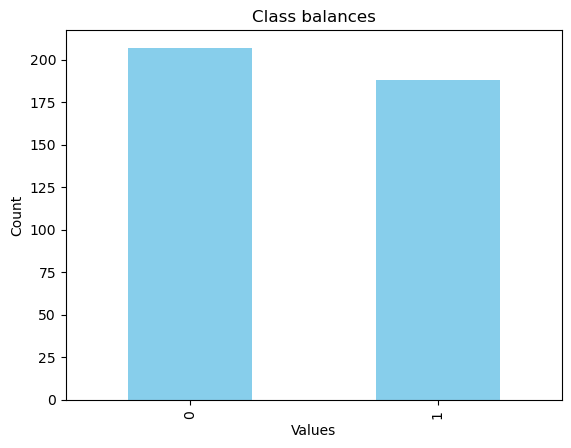

In [249]:
value_counts = tooth_labels['u'].value_counts()

# Plot a bar chart
value_counts.plot(kind='bar', color='skyblue')

# Add title and labels
plt.title('Class balances')
plt.xlabel('Values')
plt.ylabel('Count')

# Display the plot
plt.show()

### Create new dataset with class-balancing images

In [243]:
# import numpy.random as npr

# random_number_generator = npr.default_rng()
# augmented_image_store = os.path.join(image_path, 'v7')
# print(augmented_image_store)
# os.mkdir(augmented_image_store)

# def balance_column(colname, augmented_image_store):
#     value_counts = tooth_labels[colname].value_counts()
#     options = list(value_counts.index)
#     to_augment = value_counts.max() - value_counts

#     image_i = 0
#     label_df = pd.DataFrame(columns=['tooth','u'])
#     for classname, count_needed in to_augment.items():
#         print(classname, count_needed)
#         defined_value = samples_where_col_is_defined(tooth_labels, colname, options)
#         samples_of_class = defined_value.loc[defined_value[colname] == classname]
        
#         for i in range(count_needed):
#             # take random image from data that is of given class
#             random_image = npr.choice(samples_of_class.index)
#             image_label = tooth_labels.loc[random_image]
#             image = cv2.imread(image_label['image_path'])

#             # translate by a random amount
#             # x is -5 to 5, ty is -5 to 5
#             # tx, ty = np.random.RandomState.randint(10, size=2)
#             tx, ty = random_number_generator.integers(-5, 6, size=2)
#             augmented = translate(image, tx, ty)

#             # save to augmented image store
#             cv2.imwrite(os.path.join(augmented_image_store, f'{image_i}.png'), augmented)
#             image_i += 1

#             # append to labels
#             label = pd.Series({'tooth': image_label['tooth_type'], 'u': image_label['u']})
#             label_df = pd.concat([label_df, label.to_frame().T])

#     label_df.to_csv(os.path.join(augmented_image_store, 'labels.txt'), index=False)
            

# column = 'u'
# balance_column(column, augmented_image_store)

/home/riikoro/fossil_data/tooth_samples/v7
0 0
1 57
